<a href="https://colab.research.google.com/github/naevs/AI-in-Finance/blob/main/Q1(Below_Risk_Free_Rate).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and data loading

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from hyperopt import hp, fmin, atpe, tpe, STATUS_OK, Trials
from keras.optimizers import Adam
!pip install PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage, sample_cov
from pypfopt.expected_returns import returns_from_prices
from pypfopt import objective_functions
from pypfopt import risk_models, expected_returns
# Fetch daily data for 4 years
symbols=['AAPL', 'AMZN','GOOGL','BAC', 'MCD', 'CAT', 'TSLA','PFE']
from datetime import datetime, timedelta

start_date = '2017-1-1'
end_date = '2023-12-31'
df = yf.download(symbols, start_date, end_date)['Adj Close']

# Download Risk-Free Rate data
rf_rate_symbol = '^IRX'
rf_rate_data = yf.download(rf_rate_symbol, start=start_date, end=end_date)['Adj Close']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.4 MB/s eta 0:00:00


[*********************100%%**********************]  8 of 8 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
dfa = df[df.index <= pd.Timestamp('2023-01-01')]

# Question 1a

Covariance Matrix:
 Ticker      AAPL      AMZN       BAC       CAT     GOOGL       MCD       PFE  \
Ticker                                                                         
AAPL    0.001600  0.000916  0.000687  0.000483  0.000882  0.000537  0.000418   
AMZN    0.000916  0.001886  0.000580  0.000494  0.001033  0.000353  0.000303   
BAC     0.000687  0.000580  0.002091  0.001214  0.000784  0.000627  0.000426   
CAT     0.000483  0.000494  0.001214  0.001877  0.000599  0.000522  0.000484   
GOOGL   0.000882  0.001033  0.000784  0.000599  0.001383  0.000468  0.000398   
MCD     0.000537  0.000353  0.000627  0.000522  0.000468  0.000813  0.000314   
PFE     0.000418  0.000303  0.000426  0.000484  0.000398  0.000314  0.001133   
TSLA    0.001556  0.001502  0.001091  0.000896  0.001229  0.000882  0.000542   

Ticker      TSLA  
Ticker            
AAPL    0.001556  
AMZN    0.001502  
BAC     0.001091  
CAT     0.000896  
GOOGL   0.001229  
MCD     0.000882  
PFE     0.000542  
TSLA    

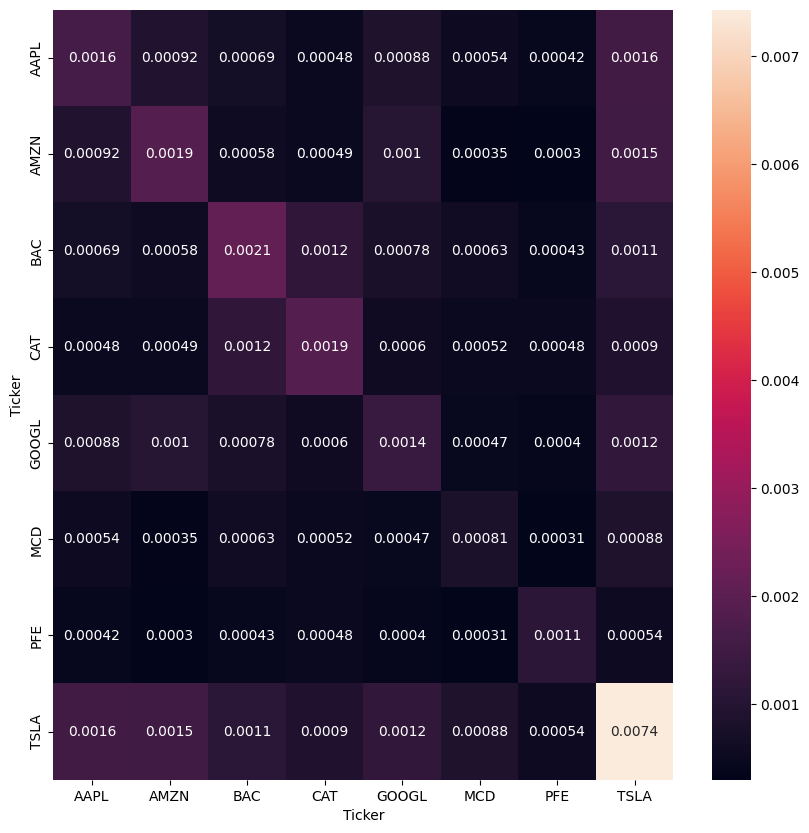

In [5]:
# Calculate weekly returns
df_weekly_returns = dfa.resample('W').last().pct_change().dropna()

# Estimate the covariance matrix
covariance_matrix = df_weekly_returns.cov()
print("Covariance Matrix:\n", covariance_matrix)

plt.figure(figsize=(10, 10))
sns.heatmap(covariance_matrix, annot=True)
plt.show()

#Question 1b

In [6]:
def prepare_data(stock_data, start_date, end_date):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(stock_data.values.reshape(-1, 1))

    forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
    forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')

    data_train = data_scaled[:forecast_start_idx - sequence_length]
    data_test = data_scaled[forecast_start_idx - sequence_length:forecast_end_idx + 1]

    train_generator = TimeseriesGenerator(data_train, data_train, length=sequence_length, batch_size=1)
    test_generator = TimeseriesGenerator(data_test, data_test, length=sequence_length, batch_size=1)

    X_train, y_train = zip(*[gen for gen in train_generator])
    X_test, y_test = zip(*[gen for gen in test_generator])

    X_train = np.squeeze(np.array(X_train), axis=1)
    y_train = np.squeeze(np.array(y_train), axis=1)
    X_test = np.squeeze(np.array(X_test), axis=1)
    y_test = np.squeeze(np.array(y_test), axis=1)

    return X_train, y_train, X_test, y_test, scaler


sequence_length = 60
X_train, y_train, X_test, y_test, scaler = prepare_data(df, start_date='2022-12-23', end_date='2022-12-31')

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1385, 60, 1)
y_train shape: (1385, 1)
X_test shape: (5, 60, 1)
y_test shape: (5, 1)


<ipython-input-6-42406eb44b12>:5: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_start_idx = stock_data.index.get_loc(start_date, method='bfill')
<ipython-input-6-42406eb44b12>:6: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  forecast_end_idx = stock_data.index.get_loc(end_date, method='ffill')


In [7]:
def lstm_model(params):
    model = Sequential()
    model.add(LSTM(units=int(params['units']), input_shape=(60, 1), return_sequences=params['num_lstm_layers'] > 1))
    model.add(Dropout(params['dropout_rate']))

    for i in range(1, params['num_lstm_layers']):
        if i == params['num_lstm_layers'] - 1:
            model.add(LSTM(units=int(params['units']), return_sequences=False))
        else:
            model.add(LSTM(units=int(params['units']), return_sequences=True))
        model.add(Dropout(params['dropout_rate']))

    model.add(Dense(1))
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0)
    model.fit(X_train, y_train, epochs=int(params['epochs']), batch_size=int(params['batch_size']), verbose=0, callbacks=[early_stop])
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return {'loss': mse, 'status': STATUS_OK}

space = {
    'units': hp.choice('units', [50, 100, 150]),
    'num_lstm_layers': hp.choice('num_lstm_layers', [1, 2, 3]),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    'epochs': hp.choice('epochs', [50, 100, 150]),
    'batch_size': hp.choice('batch_size', [16, 32, 64])
}

trials = Trials()
best = fmin(lstm_model, space, algo=tpe.suggest, max_evals=30, trials=trials)

print("Best hyperparameters:", best)

1/1 [==============================] - 1s 641ms/step

1/1 [==============================] - 0s 340ms/step

1/1 [==============================] - 1s 620ms/step

1/1 [==============================] - 0s 341ms/step

 13%|█▎        | 4/30 [00:58<06:16, 14.48s/trial, best loss: 0.00012282235233775337]

1/1 [==============================] - 1s 615ms/step

 17%|█▋        | 5/30 [01:24<07:53, 18.93s/trial, best loss: 0.00012282235233775337]

1/1 [==============================] - 1s 923ms/step

1/1 [==============================] - 1s 902ms/step

1/1 [==============================] - 1s 896ms/step

1/1 [==============================] - 0s 334ms/step

1/1 [==============================] - 1s 915ms/step

1/1 [==============================] - 1s 621ms/step

1/1 [==============================] - 0s 338ms/step

1/1 [==============================] - 0s 347ms/step

1/1 [==============================] - 1s 1s/step

1/1 [==============================] - 0s 334ms/step

1/1 [==============================] - 1s 624ms/step

1/1 [==============================] - 1s 903ms/step

1/1 [==============================] - 1s 616ms/step

1/1 [==============================] - 1s 917ms/step

1/1 [==============================] - 1s 615ms/step

1/1 [==============================] - 1s 914ms/step

1/1 [==============================] - 0s 336ms/step

1/1 [==============================] - 0s 353ms/step

1/1 [==========================

In [ ]:
#Best hyperparameters: {'batch_size': 1, 'dropout_rate': 0.0404142976138005, 'epochs': 2, 'learning_rate': 0.0007027051382614165, 'num_lstm_layers': 2, 'units': 2}

#Question 1c

In [ ]:
stock_forecasts = {}
stock_actual = {}

for symbol in symbols:
    print(f"Processing {symbol}")
    stock_data = df[symbol]

    X_train, y_train, X_test, y_test, scaler = prepare_data(stock_data, start_date='2023-1-1', end_date='2023-1-7')

    units = 100
    num_lstm_layers = 2
    dropout_rate = 0.0404142976138005
    learning_rate = 0.0007027051382614165
    epochs = 150
    batch_size = 32

    model = Sequential()
    model.add(LSTM(units, input_shape=(sequence_length, 1), return_sequences=True))
    model.add(Dropout(dropout_rate))
    if num_lstm_layers > 1:
        for _ in range(1, num_lstm_layers):
            model.add(LSTM(units, return_sequences=True))
            model.add(Dropout(dropout_rate))
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    model.summary()

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Predict
    predictions_scaled = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions_scaled)

    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    stock_forecasts[symbol] = predictions[-1]
    stock_actual[symbol] = actual_prices[-1]
    model.reset_states()

In [10]:
stock_actual

{'AAPL': array([128.73522949]),
 'AMZN': array([86.08000183]),
 'GOOGL': array([87.33999634]),
 'BAC': array([33.13751984]),
 'MCD': array([262.01358032]),
 'CAT': array([242.74298096]),
 'TSLA': array([113.05999756]),
 'PFE': array([47.98777008])}

In [11]:
stock_forecasts

{'AAPL': array([126.87665], dtype=float32),
 'AMZN': array([83.05547], dtype=float32),
 'GOOGL': array([86.28864], dtype=float32),
 'BAC': array([33.323795], dtype=float32),
 'MCD': array([254.87839], dtype=float32),
 'CAT': array([232.9811], dtype=float32),
 'TSLA': array([113.51995], dtype=float32),
 'PFE': array([46.322712], dtype=float32)}

In [12]:
expected_returns = {symbol: (stock_forecasts[symbol][0] - stock_actual[symbol][0]) / stock_actual[symbol][0] for symbol in stock_forecasts}
print("Expected Returns:")
for symbol, expected_return in expected_returns.items():
    print(f"{symbol}: {expected_return:.4f}")

Expected Returns:
AAPL: -0.0144
AMZN: -0.0351
GOOGL: -0.0120
BAC: 0.0056
MCD: -0.0272
CAT: -0.0402
TSLA: 0.0041
PFE: -0.0347


In [13]:
weekly_rf_rate = rf_rate_data['2023-01-03']
weekly_rf_rate = weekly_rf_rate/100
weekly_rf_rate = weekly_rf_rate.mean()
weekly_rf_rate

0.04255000114440918

In [14]:
dfa = df[df.index <= pd.Timestamp('2022-12-31')]
df_weekly = dfa.resample('W').last()
df_weekly_returns = df_weekly.pct_change().dropna()
cov_matrix = df_weekly_returns.cov()

expected_returns_list = pd.Series({
    'AAPL': -0.0144,
    'AMZN': -0.0351,
    'CAT': -0.0402,
    'GOOGL': -0.0120,
    'MCD': -0.0272,
    'BAC': 0.0056,
    'PFE': -0.0347,
    'TSLA': 0.0041,
})
ef = EfficientFrontier(expected_returns_list, cov_matrix, weight_bounds=(0, 1))
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
cleaned_weights = ef.max_sharpe(risk_free_rate=weekly_rf_rate)

cleaned_weights = ef.clean_weights()

print("Optimized Portfolio Weights:")
print(cleaned_weights)

ef.portfolio_performance(verbose=True, risk_free_rate=weekly_rf_rate)

ValueError: at least one of the assets must have an expected return exceeding the risk-free rate

# Due to the Expected Return been less than the Risk Free Rate, we can't use the current Stock Ticker Examples to curate a portfolio. Hence we switched the below stock tickers:-           

1) CAT ---> MCD

2) BAC ---> GM

As shown in Q1(Above Risk-Free-Rate) we were able to curate a portfolio that successfully addresses this question and the following questions.